# initialize

In [1]:
import matplotlib.pyplot as plt

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("MDA_2021") \
    .master("local[*]") \
    .getOrCreate()

sc=spark.sparkContext

22/12/17 22:28:10 WARN Utils: Your hostname, mostafa-UX410UQK resolves to a loopback address: 127.0.1.1; using 192.168.0.100 instead (on interface wlp2s0)
22/12/17 22:28:10 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/12/17 22:28:11 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Reading file & Preprocessing

In [4]:
rddFromFile = sc.textFile("./Sample_Traffic.csv") # Now you have a RDD with wikipedia posts
rddFromFile.take(3)

['DEVICE_CODE,SYSTEM_ID,ORIGINE_CAR_KEY,FINAL_CAR_KEY,CHECK_STATUS_KEY,COMPANY_ID,PASS_DAY_TIME',
 '200501,81,10477885,10477885,5,161,2021-06-01 03:54:39',
 '155,81,87625017,87625017,5,161,2021-06-01 04:14:21']

### save header and remove from numerical data

In [5]:
from itertools import islice

def remove_header(splitIndex, iterator):
    
    if splitIndex == 0 :
        
        return islice(iterator , 1, len(list(iterator))-1)
    else:

        return iterator


traffic_data_rdd = rddFromFile.map(lambda x:x.split(",")).mapPartitionsWithIndex(remove_header)
print(traffic_data_rdd.take(2))

[['100700838', '283', '20364724', '20364724', '5', '264', '2021-06-01 05:34:52'], ['900151', '283', '20364724', '20364724', '5', '264', '2021-06-01 05:28:56']]


# A-Priori

### basket-items rdd

In [6]:

plaque_camera_rdd = traffic_data_rdd.filter(lambda x:(x[4] in ["1","2","3","5","6","7"]) and (x[0]!=""))\
    .map(lambda x: ((int(x[3]),x[6].split(" ")[0]) , (int(x[0]) ,int(x[4])))).map(lambda x:(x[0] , x[1][0]))

### maybe it's not needed to filter!
# output 1&2
## (key = (final_plaque , date) , value = (camera_code , check_status_code))
# output 3
## (key = (final_plaque , date) , value = camera_code )

cameras_lists_rdd = plaque_camera_rdd.groupByKey().mapValues(lambda x: list(set(x))).map(lambda x:x[1]).cache()
# output 1
## (key = (final_plaque , date) , value = [camera_code1, camera_code2,...]  )
# output 2
## [[camera_code1, camera_code2,...],[..],... ]



### baskets_count

In [7]:
baskets_count =  cameras_lists_rdd.count()
baskets_count

1382709

### one-items

In [8]:
one_items_count_rdd = plaque_camera_rdd.map(lambda x:(x[1] ,1)).reduceByKey(lambda x,y:x+y)
# output 1
## (key = camera_code ,  value = 1 )
# output 2
## (key = camera_code ,  value = countk )

#### histogram of #baskets (transaction) for items(camera)

In [9]:
histogram_data = one_items_count_rdd.map(lambda x:x[1]).histogram(10)

([1.0, 8401.9, 16802.8, 25203.699999999997, 33604.6, 42005.5, 50406.399999999994, 58807.299999999996, 67208.2, 75609.09999999999, 84010], [831, 68, 41, 15, 12, 7, 4, 2, 1, 1])


Text(0, 0.5, 'number of cameras')

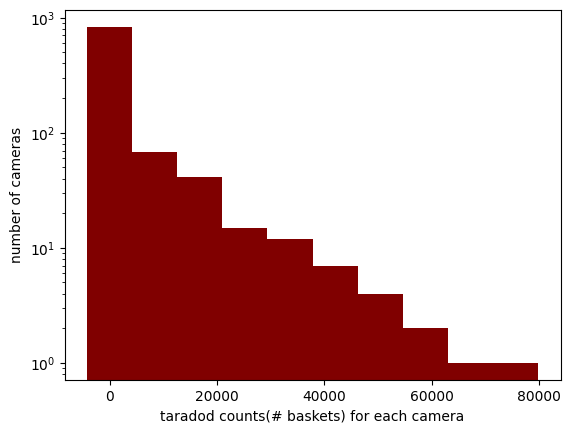

In [11]:
print(histogram_data)
plt.bar(histogram_data[0][0:-1],histogram_data[1], color ='maroon',width = 8400)
plt.yscale('log')
plt.xlabel('taradod counts(# baskets) for each camera')
plt.ylabel('number of cameras')

So we can choose support threshold based on this ! It is rational to choose threshold so that we can introduce the count of most heavy traffic points in order of 100. so I choose threshold=10000.

#### filter one frequent items

In [24]:
# SUPPORT_THRESH_PERCENT = 0.2
# SUPPORT_THRESH = SUPPORT_THRESH_PERCENT*baskets_count
SUPPORT_THRESH = 25000

one_frequent_items = one_items_count_rdd.filter(lambda x:x[1]>=SUPPORT_THRESH).map(lambda x:x[0]).collect()

print(len(one_frequent_items))
print(one_frequent_items)

42
[100700864, 100700824, 100700841, 100700881, 900233, 900273, 900185, 900265, 22009977, 900225, 900249, 900217, 900234, 100700866, 900202, 900107, 900259, 900155, 900139, 22010083, 900164, 900212, 900268, 100700804, 100700868, 900244, 900236, 100700845, 100700853, 900269, 900101, 22010061, 900246, 22010118, 900222, 100700862, 900142, 900102, 22010119, 900191, 100700839, 900207]


### Step 2

#### k>=2 frequent itemsets

In [15]:
def remove_and_sort_replicates(x):
    
    if(isinstance(x[0], tuple)):
        x1 = x[0]
        x2 = x[1]

    else:
        x1 = [x[0]]
        x2 = x[1]
        
    if (any(item == x2 for item in x1) == False):
        item_list = list(x1)
        item_list.append(x2)
        item_list = tuple(sorted(item_list))
        return item_list
    else:
        return x1


In [25]:

frequent_itemset = []


k=2

one_frequent_items_rdd = sc.parallelize(one_frequent_items)
# output 
## [frequent_code1, frequent_code2 ,..frequent_codem]
    
k_iad_frequent_items = one_frequent_items

while(len(k_iad_frequent_items)!=0):#

    frequent_itemset.append(k_iad_frequent_items)
    k_iad_frequent_items_rdd = sc.parallelize(k_iad_frequent_items)
    k_iad_candidates_rdd = k_iad_frequent_items_rdd.cartesian(one_frequent_items_rdd).map(remove_and_sort_replicates).filter(lambda x:len(x)==k).distinct()
    # output 1
    ## [((frequent_code1, frequent_code1),..frequent_codem),((frequent_code1, frequent_code2),..frequent_codem) ,..., ((frequent_code2, frequent_code1),..frequent_codem),...]
    # output 2
    ## [(frequent_code1, frequent_code2 ,...,frequent_codem),(frequent_code1, frequent_code3,..frequent_codem) ,...]

    k_iad_frequent_items_rdd = k_iad_candidates_rdd.cartesian(cameras_lists_rdd).filter(lambda x: all(frequent_item in x[1] for frequent_item in x[0]))\
        .map(lambda x:(x[0],1)).reduceByKey(lambda x,y:x+y).filter(lambda x:x[1]>=SUPPORT_THRESH).map(lambda x:x[0])
    
    # output 1&2
    ## [((frequent_code1, frequent_code2,...,frequent_codem),[camera_code1, camera_code2,...]),((frequent_code1, frequent_code3,...,frequent_codem),[camera_code1, camera_code2,...]) ,...]
    # output 2
    ## [((frequent_code1, frequent_code2,...,frequent_codem),[camera_code1, camera_code2,...]),((frequent_code1, frequent_code3,...,frequent_codem),[camera_code1, camera_code2,...]) ,...]
    # output 3
    ## [((frequent_code1, frequent_code2,...,frequent_codem),1),((frequent_code1, frequent_code3,...,frequent_codem),1) ,...]
    # output 4 &5
    ## [((frequent_code1, frequent_code2,...,frequent_codem),countk),((frequent_code1, frequent_code3,...,frequent_codem),countk) ,...]
    # output 6
    ## [(frequent_code1, frequent_code2,...,frequent_codem),(frequent_code1, frequent_code3,...,frequent_codem) ,...]

    k_iad_frequent_items = k_iad_frequent_items_rdd.collect()
    

    k +=1

print(frequent_itemset)



[[100700864, 100700824, 100700841, 100700881, 900233, 900273, 900185, 900265, 22009977, 900225, 900249, 900217, 900234, 100700866, 900202, 900107, 900259, 900155, 900139, 22010083, 900164, 900212, 900268, 100700804, 100700868, 900244, 900236, 100700845, 100700853, 900269, 900101, 22010061, 900246, 22010118, 900222, 100700862, 900142, 900102, 22010119, 900191, 100700839, 900207], [(900212, 900244)]]


# SON algorithm

In [26]:
Num_partitions = cameras_lists_rdd.getNumPartitions()

In [27]:
from itertools import product




def get_local_frequent_itemsets(iterator):
    
    def filter_replicates(product_list ,k):


        item_list = []

        for product_item in product_list:
            
            
            if(isinstance(product_item[0], tuple)):
                x1 = list(product_item[0])
                x2 = [product_item[1]]

            else:
                x1 = [product_item[0]]
                x2 = [product_item[1]]


            
            
            item = set().union(sorted(x1 + x2))
            
            if len(item) == k :
                item_list.append(tuple(item))
        
        ## returns a set
        return set().union(item_list)

    
    basket_lists = list(iterator)
    
    # basket_numbers = len(basket_lists)

    all_baskets = []

    for basket_list in basket_lists:
        all_baskets += basket_list 

    unique_items = set().union(all_baskets)


    one_frequent_items_in_local_baskets = []


    for item in unique_items:
        
        item_counter = 0
        
        for basket in basket_lists:
            
            if item in  basket:
                item_counter+=1
        
        if item_counter>= SUPPORT_THRESH//Num_partitions:
            one_frequent_items_in_local_baskets.append(item)




    frequent_itemsets = []    


    k_iad_frequent_candidates = one_frequent_items_in_local_baskets
    k=2
    
    while len(k_iad_frequent_candidates)!=0:

        frequent_itemsets.append(k_iad_frequent_candidates)
        k_iad_candidates = filter_replicates(list(product(k_iad_frequent_candidates ,one_frequent_items_in_local_baskets)) , k)
        
        # ouput
        ## set of k_iad_candidates {(code1,..,codek) ,(codem ,... code m+k-1) ,...}

        k_iad_frequent_candidates = []

        for k_iad_candidate in k_iad_candidates:
            
            k_iad_candidate_counter = 0

            for basket in basket_lists:
            
                if all(frquent_one_item in basket for frquent_one_item in k_iad_candidate):
                    
                    k_iad_candidate_counter +=1
                    
        

            if k_iad_candidate_counter >= SUPPORT_THRESH//Num_partitions:

                k_iad_frequent_candidates.append(k_iad_candidate)
                
        k+=1   
        
    

    return frequent_itemsets
            



In [28]:

local_frequent_itemsets = cameras_lists_rdd.mapPartitions(get_local_frequent_itemsets).collect()  

print(local_frequent_itemsets)

# input
## [[camera_code1, camera_code2,...],[..],... ]

[[22010119, 100700804, 100700824, 100700841, 100700845, 100700853, 100700862, 100700866, 100700868, 900101, 900102, 900107, 900139, 900142, 900155, 900164, 900191, 900202, 900207, 900212, 900222, 900225, 900234, 900236, 900244, 900246, 900249, 900265, 900268, 900269], [(900244, 900212)], [22010119, 100700804, 100700824, 100700841, 100700845, 100700853, 100700862, 100700866, 100700868, 900101, 900102, 900107, 900139, 900142, 900155, 900164, 900191, 900202, 900207, 900212, 900225, 900222, 900234, 900236, 900244, 900246, 900249, 900265, 900268, 900269], [(900244, 900212)], [22010119, 100700804, 100700824, 100700839, 100700841, 100700845, 100700853, 100700862, 100700866, 100700868, 900101, 900102, 900107, 900139, 900142, 900155, 900164, 900191, 900202, 900207, 900212, 900222, 900225, 900234, 900236, 900244, 900246, 900249, 900265, 900268, 900269], [(900244, 900212)], [22010119, 100700804, 100700824, 100700841, 100700845, 100700853, 100700862, 100700866, 100700868, 900101, 900102, 900107, 9

In [29]:
local_frequent_unique_itemsets = set()
for sub_list in local_frequent_itemsets:
        local_frequent_unique_itemsets = local_frequent_unique_itemsets.union(sub_list)
print(local_frequent_unique_itemsets)

{900225, 100700804, 900101, 900102, 22010119, 900234, 900107, 900236, 900244, 900246, (900244, 900212), 100700824, 900249, 900259, 100700839, 100700841, 900265, 900139, 900268, 100700845, 900142, 900269, 100700853, 900155, 100700862, 100700866, 100700868, 900164, 900191, 900202, 900207, 900212, 900222}


In [21]:
def check_left_items_exist_in_right_items(x):
    
    if isinstance(x[0],tuple):
        return all([frequent_item in x[1] for frequent_item in x[0]])
    else:
        return x[0] in x[1]


In [30]:


global_frequent_itemsets = sc.parallelize(local_frequent_unique_itemsets).map(lambda x:x).cartesian(cameras_lists_rdd)\
        .filter(check_left_items_exist_in_right_items).map(lambda x:(x[0],1))\
                .reduceByKey(lambda x,y:x+y).filter(lambda x:x[1]>=SUPPORT_THRESH).map(lambda x:x[0]).collect()



# output
## [(freq_item(s) , [camera_code1, camera_code2,...]),(freq_item(s) , [camera_code1, camera_code2,...]),... ]



In [33]:
print(len(global_frequent_itemsets))
print(global_frequent_itemsets )


31
[900225, 100700866, 100700804, 100700868, 900164, 900101, 900102, 22010119, 100700841, 900265, 900234, 900202, 900107, 900139, 900236, 900268, 900269, 100700845, 900142, 900207, (900244, 900212), 900244, 900212, 100700853, 900246, 100700824, 900249, 900155, 100700862, 900222, 900191]
